In [1]:
import os

from google.colab import drive
from google.colab import userdata

drive.mount('/content/drive/')

os.environ['KAGGLE_USERNAME'] = userdata.get('kaggle_username')
os.environ['KAGGLE_KEY'] = userdata.get('kaggle_token')

Mounted at /content/drive/


In [2]:
!kaggle datasets download -d ryeltsin/finger-vein

 94% 169M/181M [00:01<00:00, 73.8MB/s]
100% 181M/181M [00:01<00:00, 106MB/s] 


In [3]:
!unzip finger-vein.zip

Archive:  finger-vein.zip
  inflating: Finger Vein Database/001/left/Thumbs.db  
  inflating: Finger Vein Database/001/left/index_1.bmp  
  inflating: Finger Vein Database/001/left/index_2.bmp  
  inflating: Finger Vein Database/001/left/index_3.bmp  
  inflating: Finger Vein Database/001/left/index_4.bmp  
  inflating: Finger Vein Database/001/left/index_5.bmp  
  inflating: Finger Vein Database/001/left/index_6.bmp  
  inflating: Finger Vein Database/001/left/middle_1.bmp  
  inflating: Finger Vein Database/001/left/middle_2.bmp  
  inflating: Finger Vein Database/001/left/middle_3.bmp  
  inflating: Finger Vein Database/001/left/middle_4.bmp  
  inflating: Finger Vein Database/001/left/middle_5.bmp  
  inflating: Finger Vein Database/001/left/middle_6.bmp  
  inflating: Finger Vein Database/001/left/ring_1.bmp  
  inflating: Finger Vein Database/001/left/ring_2.bmp  
  inflating: Finger Vein Database/001/left/ring_3.bmp  
  inflating: Finger Vein Database/001/left/ring_4.bmp  
  inf

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import torchvision.datasets as dset
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

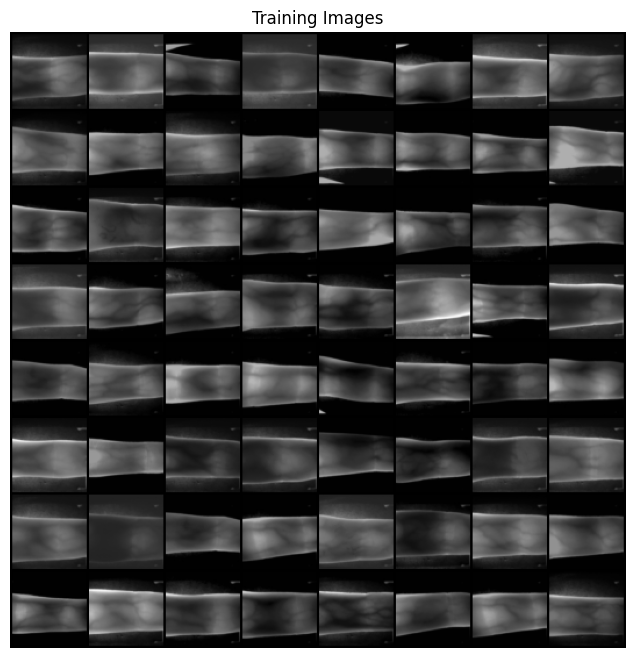

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

image_size = 64
batch_size = 64
ngpu = 1

dataset = dset.ImageFolder(root='Finger Vein Database',
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

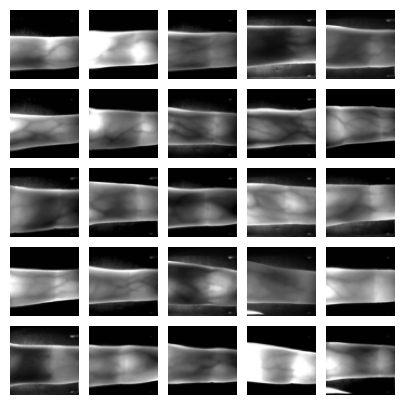

In [7]:
# get 25 sample training images for visualization
dataiter = iter(dataloader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [8]:
class VAE(nn.Module):

    def __init__(self, input_dim=4096, hidden_dim_1=1024, hidden_dim_2=512, latent_dim=256, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim_2, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim_2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim_1, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [9]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [10]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [11]:
def train(model, optimizer, epochs, device, x_dim=4096):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(dataloader):
            if len(x) != batch_size:
                continue

            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        if ((epoch + 1) % 10 == 0):
            print("Epoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [12]:
train(model, optimizer, epochs=100, device=device)

Epoch 10 	Average Loss:  1862.10645772643
Epoch 20 	Average Loss:  1856.4892578125
Epoch 30 	Average Loss:  1853.731517727092
Epoch 40 	Average Loss:  1851.3123055150954
Epoch 50 	Average Loss:  1850.8827628442796
Epoch 60 	Average Loss:  1848.0756277310645
Epoch 70 	Average Loss:  1846.4104500463454
Epoch 80 	Average Loss:  1846.5856561175847
Epoch 90 	Average Loss:  1845.8860732256355
Epoch 100 	Average Loss:  1843.8306408898304


6962304.5

In [13]:
def generate_finger(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(64, 64) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

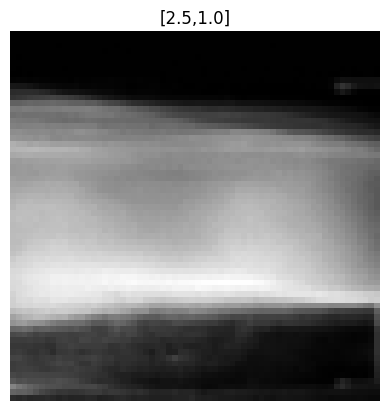

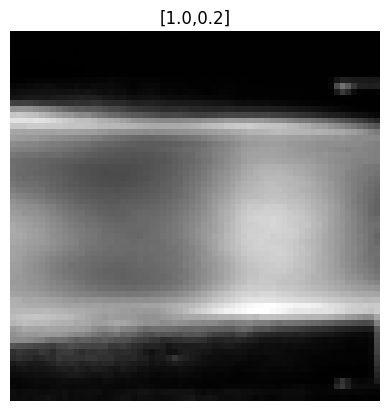

(None, None)

In [14]:
generate_finger(2.5, 1.0), generate_finger(1.0, 0.2)

In [15]:
def plot_latent_space(model, scale=5.0, n=25, finger_size=64, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((finger_size * n, finger_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(finger_size, finger_size)
            figure[i * finger_size : (i + 1) * finger_size, j * finger_size : (j + 1) * finger_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = finger_size // 2
    end_range = n * finger_size + start_range
    pixel_range = np.arange(start_range, end_range, finger_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

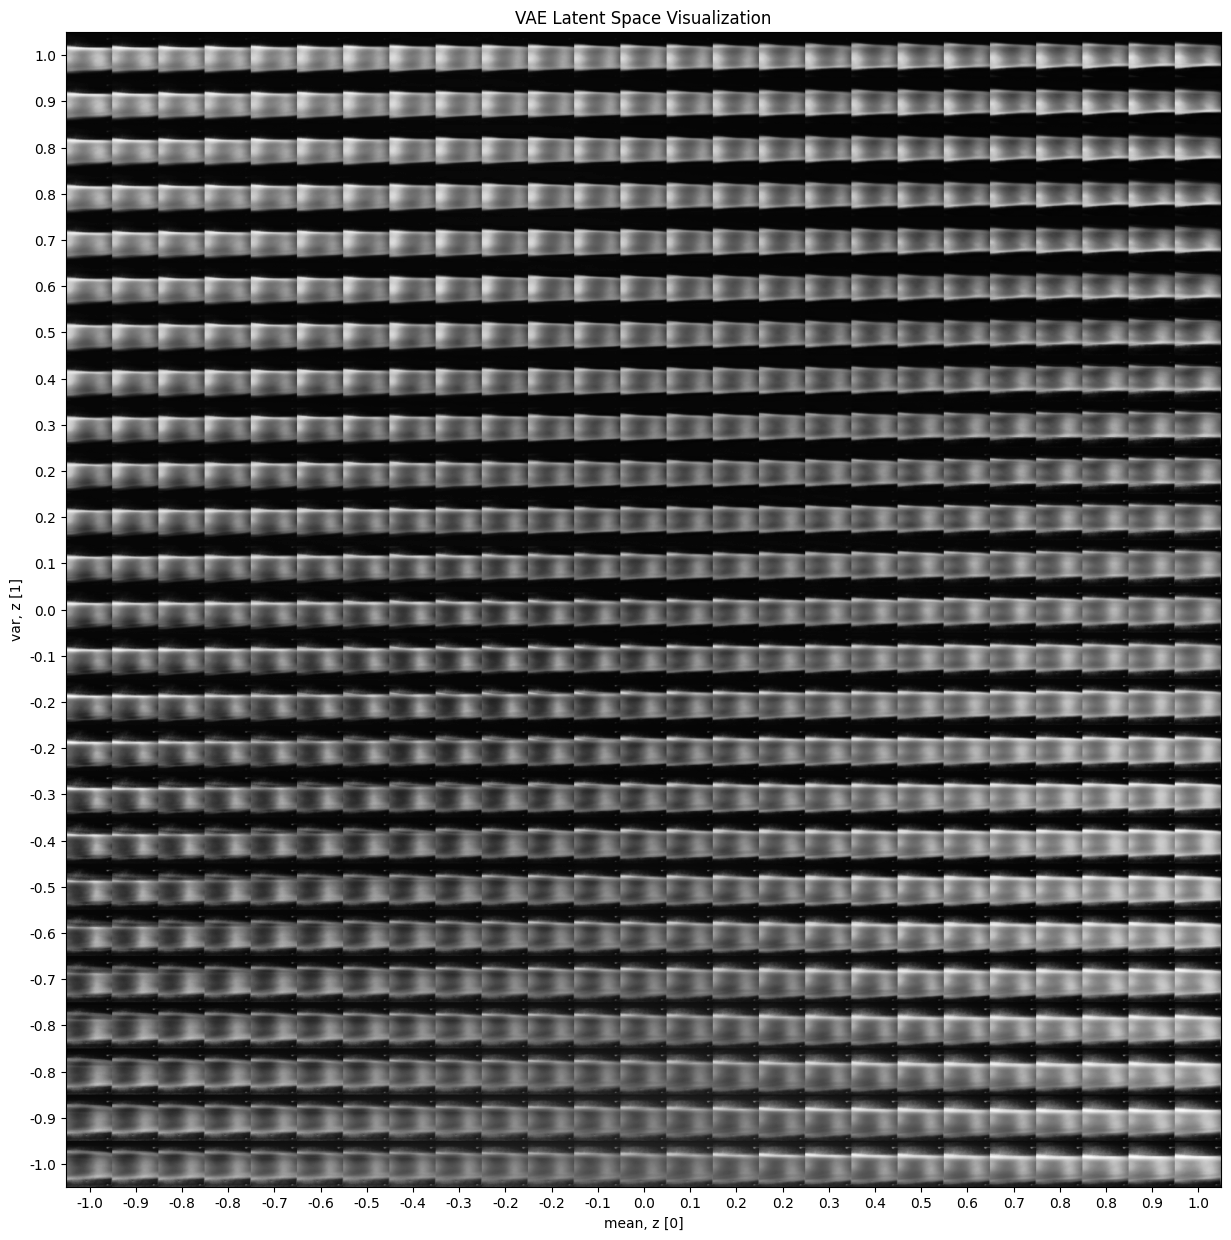

In [16]:
plot_latent_space(model, scale=1.0)